fonte: https://towardsdatascience.com/classifier-calibration-7d0be1e05452

In [6]:

from sklearn import datasets
from sklearn.model_selection import train_test_split


# create a random, binary classification problem, with 100000 samoles and 20 features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=7, n_redundant=10,
                                    random_state=42)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=42)

In [7]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


lgr = LogisticRegression(C=1, solver='lbfgs')
svc = SVC(max_iter=10000, probability=True)

In [8]:
lgr.fit(X_train, y_train).predict_proba(X_test)[:,1]

array([0.05864369, 0.68836009, 0.26473652, ..., 0.9631537 , 0.22492048,
       0.48676644])

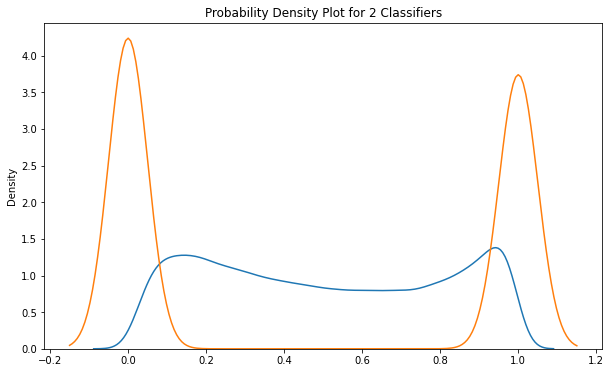

In [9]:
## somente a probabilidade de ser target = 1

probs_lgr = lgr.fit(X_train, y_train).predict_proba(X_test)[:,1]
preds_svc = svc.fit(X_train, y_train).predict(X_test)

probs_svc = svc.decision_function(X_test)
probs_svc = (probs_svc - probs_svc.min()) / (probs_svc.max() - probs_svc.min())

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(probs_lgr, label='Logistic regression')
sns.kdeplot(preds_svc, label='SVM')
plt.title("Probability Density Plot for 2 Classifiers")
plt.show()

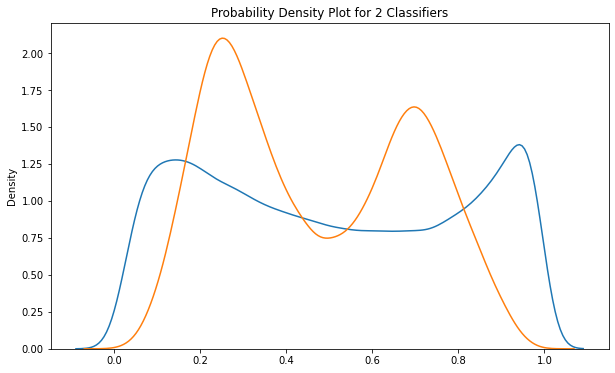

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(probs_lgr, label='Logistic regression')
sns.kdeplot(probs_svc, label='SVM')
plt.title("Probability Density Plot for 2 Classifiers")
plt.show()

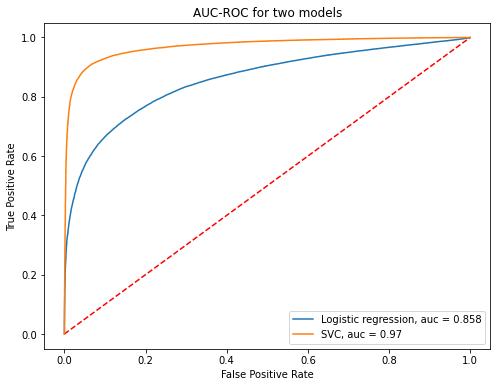

In [11]:
from sklearn import metrics


plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

pred = probs_lgr
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'Logistic regression, auc = {str(round(auc,3))}')

pred = probs_svc
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'SVC, auc = {str(round(auc,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC-ROC for two models")
plt.legend()
plt.show()

In [12]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

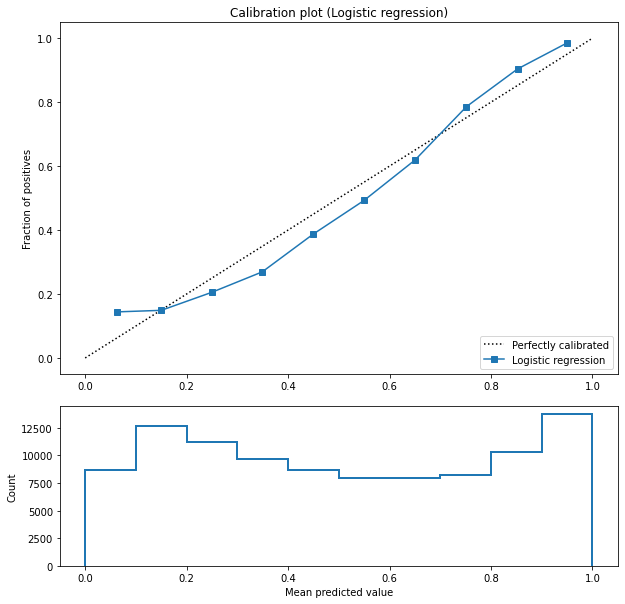

In [13]:
# plot calibration curve for logistic regression
plot_calibration_curve("Logistic regression", 1, probs_lgr)

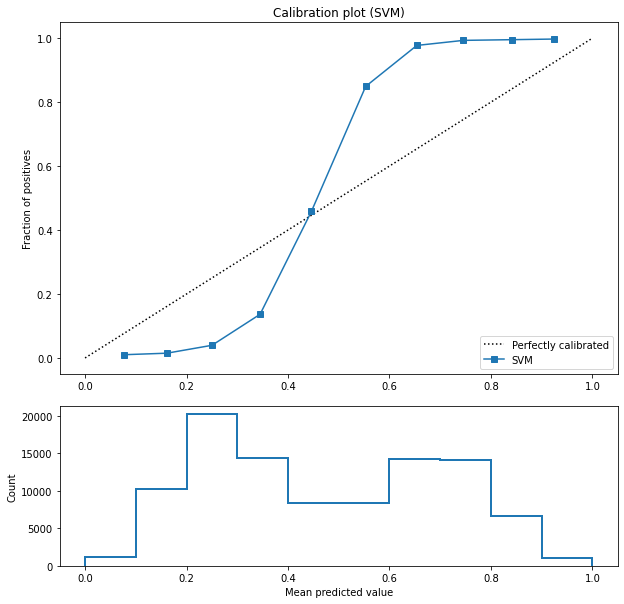

In [14]:
# plot calibration curve for the SVM
plot_calibration_curve("SVM", 1, probs_svc)

SVM possui uma alta acuracia, mas esta descalibrado. Como calibrar?

# Calibrando o modelo

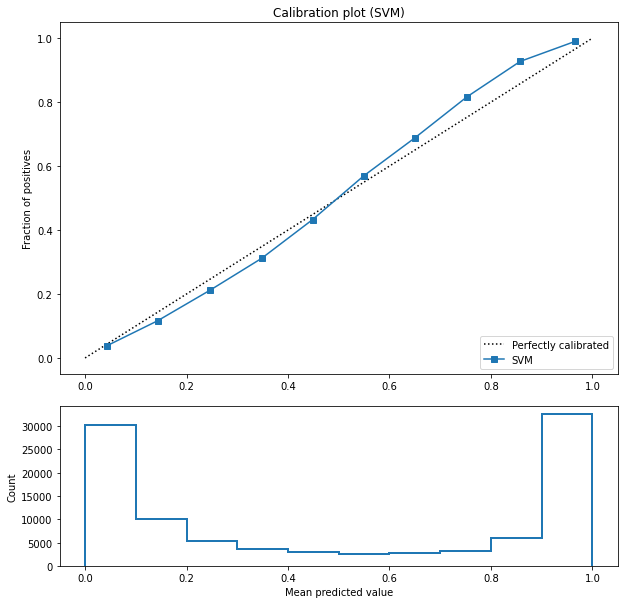

In [15]:
from sklearn.calibration import CalibratedClassifierCV


lgr = LogisticRegression(C=1, solver='lbfgs')
svc = SVC(max_iter=10000, probability=True)

platts_scaling = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("SVM", 3, calibrated_probs)

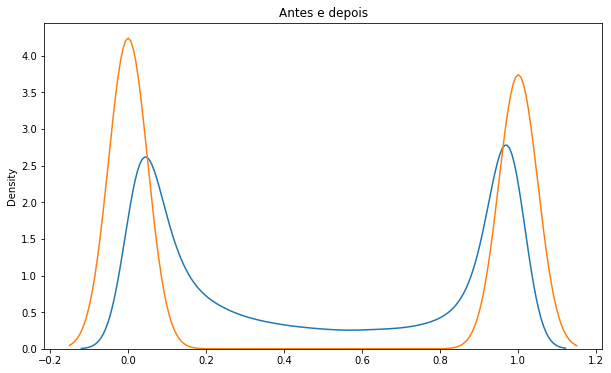

In [20]:
plt.figure(figsize=(10,6))
sns.kdeplot(calibrated_probs, label='calibrated svm')
sns.kdeplot(preds_svc, label='SVM')
plt.title("Antes e depois")
plt.show()

## isolation forest

In [16]:
import pandas as pd
df = pd.read_csv('../models/rf_df_test_if_ocsvmscore_pred.csv',sep=';', index_col=0)
df['iforest_score'] = df['iforest_score']*-1  ## quanto maior o score, maior a chance de ser uma anomalia (target =1)

df.head()

,ind_var30,var36,var15,num_var4,num_var8_0,ind_var13_0,ind_var12_0,saldo_var30,ind_var39_0,num_var30_0,...,saldo_medio_var33_hace3,num_op_var40_comer_ult3,num_var29_0,num_aport_var33_ult1,TARGET,ID,iforest_score,ocsvm_score,prob_0,prob_1
50595,1,1,45,2,0,0,0,781.47,1,3,...,0.0,0,0,0,0,101019,0.461390,1278.935705,0.854418,0.145582
5252,1,3,60,2,0,1,0,240003.00,1,6,...,0.0,0,0,0,0,10518,0.461688,7168.393634,0.974570,0.025430
21956,1,3,27,1,0,0,0,60.00,1,3,...,0.0,0,0,0,0,43966,0.457573,1069.038083,0.564292,0.435708
42714,1,1,38,3,0,0,0,293.70,1,3,...,0.0,0,0,0,0,85554,0.462192,-273.994650,0.758845,0.241155
18494,1,3,23,1,0,0,0,3.00,1,3,...,0.0,0,0,0,0,37070,0.456593,1281.258936,0.917447,0.082553


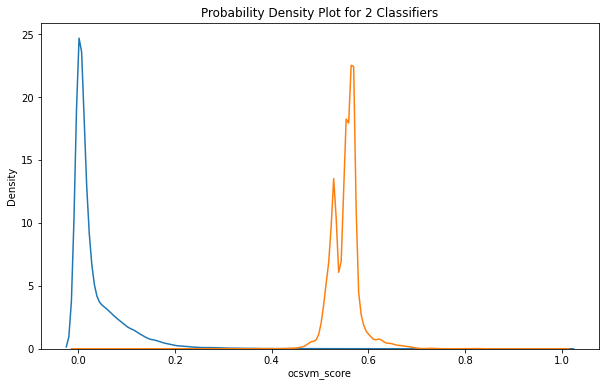

In [21]:
probs_if = df['iforest_score'].values
prob_ocsvm = df['ocsvm_score']
prob_rf = df['prob_1']

probs_if_scaled = (probs_if - probs_if.min()) / (probs_if.max() - probs_if.min())
probs_svc_scaled = (prob_ocsvm - prob_ocsvm.min()) / (prob_ocsvm.max() - prob_ocsvm.min())

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(probs_if_scaled, label='Isolation Forest')
sns.kdeplot(probs_svc_scaled, label='OCSVM')
plt.title("Probability Density Plot for 2 Classifiers")
plt.show()

Ambos os modelos possuim uma certeza quase absoluta em relação a classe.

In [44]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index,y_test, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [54]:
def plot_calib_curve(name, fig_index,y_test, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

# Iforest

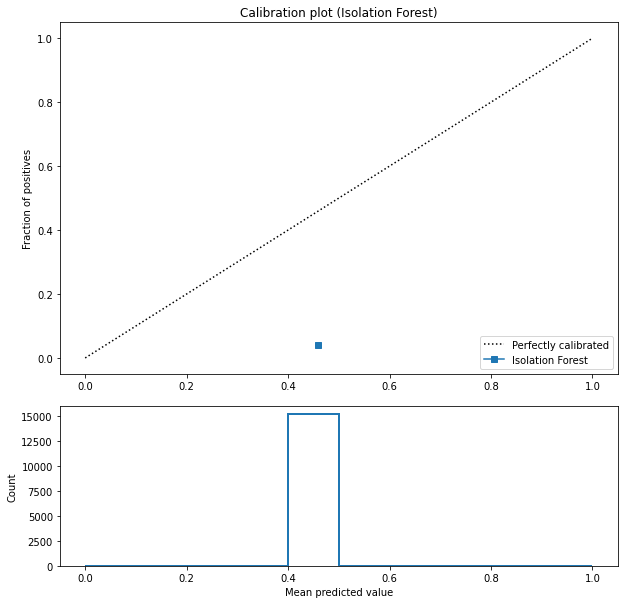

In [55]:
# plot calibration curve for logistic regression
plot_calib_curve("Isolation Forest", 100,df['TARGET'], df['iforest_score'])

In [53]:
df['iforest_score'].describe()

count    15204.000000
mean         0.457987
std          0.002428
min          0.456500
25%          0.456590
50%          0.456983
75%          0.458499
max          0.499749
Name: iforest_score, dtype: float64

não há variação no score pelo isolation forest!!

# OCSVM

In [59]:
df['prob_ocsvm_score'] = (prob_ocsvm - prob_ocsvm.min()) / (prob_ocsvm.max() - prob_ocsvm.min())

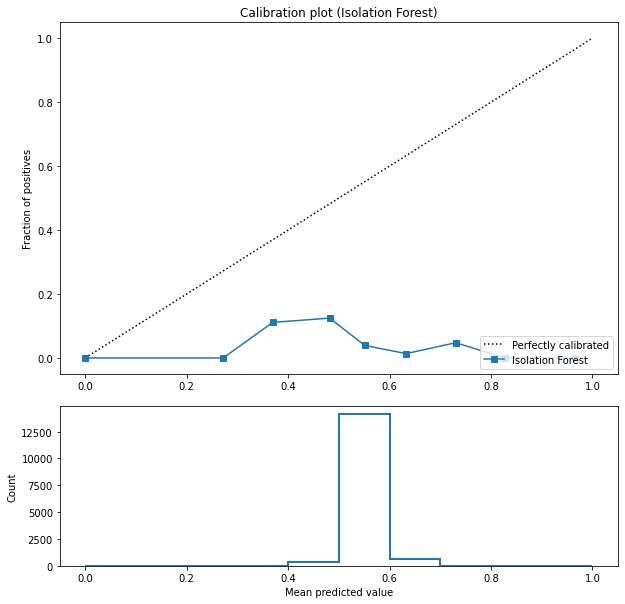

In [60]:
# plot calibration curve for logistic regression
plot_calib_curve("Isolation Forest", 100,df['TARGET'], df['prob_ocsvm_score'])

# RF

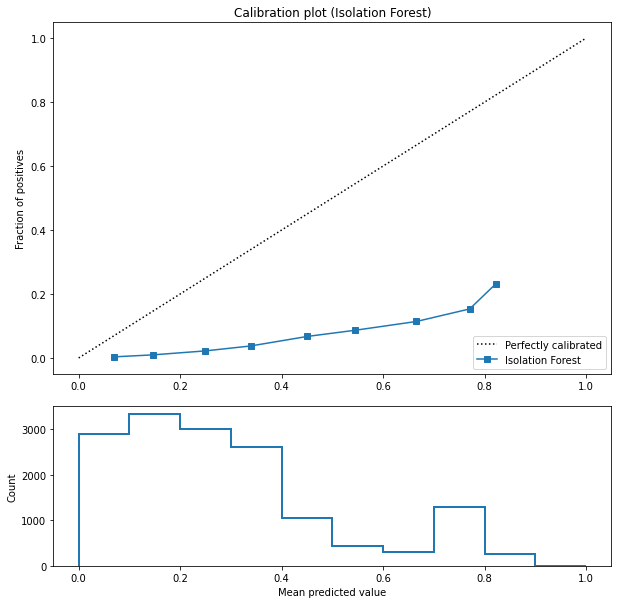

In [61]:
# plot calibration curve for logistic regression
plot_calib_curve("Isolation Forest", 100,df['TARGET'], df['prob_1'])

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# load the model from disk.
iforest_model_serialized_path = '../../models/model_iforest_kurtosisOD.pkl'
loaded_rf_model = pickle.load(open(iforest_model_serialized_path, 'rb'))



platts_scaling = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("SVM", 3, calibrated_probs)

In [56]:
X_train

array([[ 4.03388941, -1.41851049, -2.66920302, ..., -1.34006282,
         2.9270337 ,  2.33496941],
       [-0.57871703, -0.50771574, -3.23709278, ..., -0.74075987,
         0.92616531,  4.06560757],
       [ 0.31527075, -1.04887954, -0.83831322, ..., -1.00358018,
         2.15568239,  0.09594397],
       ...,
       [ 1.16946931, -1.47698354, -0.26983363, ...,  3.92645361,
         0.55299976, -1.1916269 ],
       [ 1.64006901, -0.19665753, -2.92376296, ...,  1.32895989,
         1.59508927, -0.74035181],
       [ 0.55224129,  1.30873877, -0.09764096, ..., -2.62821317,
        -0.40027529,  0.67129445]])